# Machine Learning

## Classification

Comes from [Recommendation / Summarization.](https://github.com/luisecastro/dataInc/blob/master/rec_sum.ipynb)

With the data gathered and created, test the capacity of supervised classification models to accurately predict the genre of a script.

To do so the models are tested againts the given genre at IMDB, the models are tunned to check which parameters are the best for each model, and which features should be chosen to increase accuracy and which should be omitted.

Following import the dataset.

In [1]:
import pandas as pd
dfpp = pd.read_csv('data/dfpp.csv',index_col=0)
df   = pd.read_csv('data/df.csv',index_col=0)

For a crossvalidated grid search, the minimum of instances per class has to be greater that the number of folds, identify classes with less that 3 instances. Correct a leading space in the Genre2 feature, then proceed to identify classes as with Genre1.

In [209]:
remove1 = pd.Series(dfpp['Genre1'].value_counts()>3)
remove1 = pd.Series(dfpp['Genre1'].value_counts()>3).index[remove1==False]
print remove1

Index([u'Adult', u'Musical', u'History', u'Film-Noir', u'War', u'Reality-TV'], dtype='object')


Define **'strip'** to remove leading space.

In [6]:
def strip(x):
    return str(x).strip()

In [210]:
remove2 = pd.Series(dfpp['Genre2'].value_counts()>3)
remove2 = pd.Series(dfpp['Genre2'].value_counts()>3).index[remove2==False]
print remove2

Index([u'Sci-Fi', u'Short', u'Adult', u'Family', u' Documentary',
       u' Reality-TV', u'Reality-TV', u' Game-Show', u'Crime', u'History'],
      dtype='object')


Remove classes from the target and train datasets.

In [211]:
index = []

for i, j in zip(dfpp['Genre1'],dfpp['Genre2']):
    if i in remove1 or j in remove2:
        index.append(False)
    else:
        index.append(True)
        
train   = dfpp[dfpp.columns[:44]].ix[index]      
target1 = dfpp['Genre1'].ix[index]
target2 = dfpp['Genre2'].ix[index]

Define functions for working with data:
- **'train_test'** splits the dataset randomly into train and test sets.
- **'accuracy'** calculates the the number of right predictions / total predictions.
- **'transform'** changes string classes to numeric.

In [11]:
import numpy as np

def train_test(x,size=0.7,boot=False,seed=0):
    np.random.seed(seed)
    r = range(len(x))
    train = sorted(np.random.choice(r,size= int(len(x)*size),replace=boot))
    test = []
    for i in r:
        if i not in train:
            test.append(i)
    return train, test

In [12]:
def accuracy(x,y):
    result = []
    for i,j in zip(x,y):
        result.append(i==j)
    return sum(result)/float(len(x))

In [13]:
def transform(x):
    cats   = []
    unique = list(target1.unique())
    
    for i in list(target1.values):
        cats.append(unique.index(i))
    return cats

Perform a gridsearch to tune the ML models, by providing ranges of values to the tuning parameters, the function returns the parameters that have the best accuracy, this parameters will be used when performing the classification.

### Support Vector

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf','linear','sigmoid'],'gamma':[0.005,0.01,0.05],'C':[2.,4.,8.]}
clf        = SVC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.472982975574
{'kernel': 'rbf', 'C': 4.0, 'gamma': 0.01}


### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier as RFC

parameters = {'n_estimators':[200,250,300],'max_depth':[10,11,11]}
clf        = RFC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.438934122872
{'n_estimators': 250, 'max_depth': 11}


### K-Nearest Neighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier as KNC

parameters = {'n_neighbors':[10,15,20],'weights':['uniform','distance']}
clf        = KNC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.430792005922
{'n_neighbors': 15, 'weights': 'distance'}


### Adaptative Boosting

In [16]:
parameters = {'n_estimators':[50,100,200],'learning_rate':[0.01,0.05,0.1]}
clf        = ABC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.350851221318
{'n_estimators': 100, 'learning_rate': 0.05}


The best algorithm was **SVC** with almost **48%** of accuracy, train and tune it for Genre2 and see how it performs predicting either of them.

In [19]:
parameters = {'kernel':['rbf','linear','sigmoid'],'gamma':[0.001,0.005,0.01],'C':[2.,4.,8.]}
clf        = SVC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target2)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.316802368616
{'kernel': 'rbf', 'C': 4.0, 'gamma': 0.005}


Around 74% chance to predict correctly the at least one of the two first listed genres for the script.

## Regression

Define **'rmse'** function to calculate the Root Mean Square error of prediction vs. target.

In [22]:
def rmse(x,y):
    samples = float(len(x))
    result  = 0.
    for i, j in zip(x,y):
        result += (i-j)**2/samples
    return result**0.5

### K-Nearest Neighbors

Define **'knn_tune'** a tuning function for KNN.

In [49]:
from sklearn.neighbors import KNeighborsRegressor as KNR

def knn_tune(train,target,columns,ind=40,n=0.7,rep=10):
    predictions = pd.DataFrame(data=np.zeros(shape=(ind,len(columns))),
                               columns=columns,
                               index=range(1,ind+1))
    
    for seed in range(1,rep+1):
        train_index, test_index = train_test(target,n,seed)
        train_i                 = train.ix[train_index]
        test_i                  = train.ix[test_index]
        target_train            = target.ix[train_index]
        target_test             = target.ix[test_index]

        for neig in range(1,ind+1):
            for opt in columns:
                clf = KNR(n_neighbors=neig,weights=opt)
                clf.fit(train_i,target_train.ravel())
                knrpred = clf.predict(test_i)
                predictions[opt][neig] += rmse(knrpred,target_test)/rep
                
    return predictions

Define train, test and target datasets and function.

In [60]:
index    = ~dfpp['imdbRating'].isnull()
target   = dfpp['imdbRating'].ix[index]
train    = dfpp[dfpp.columns[:44]].ix[index]
columns  = ['uniform','distance']
tune     = knn_tune(train,target,columns)

Plot the results.

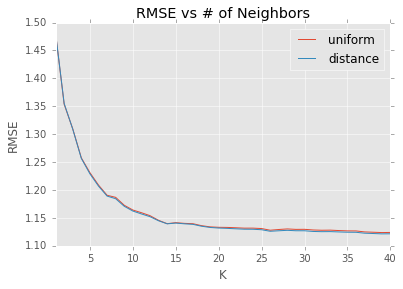

In [57]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

tune.plot()
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE vs # of Neighbors')
plt.show()

In [69]:
print tune.sort_values(by='uniform').head(1)
print tune.sort_values(by='distance').head(1)

     uniform  distance
39  1.123715  1.121405
     uniform  distance
39  1.123715  1.121405


### Benchmark

Define a benchmark, in this case the RMSE of the population vs. the mean of the population.

In [58]:
others = []
for i in range(target.shape[0]):
    others.append((target.iloc[i]-np.mean(target))**2)
    
print (sum(others)/len(others))**0.5

1.19112368745


### Support Vector Regression

Follow the same procedure with SVR, will use the for metrics.

In [61]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

parameters = {'kernel':['rbf','linear','sigmoid'],'gamma':[0.001,0.005,0.01],'C':[1.,2.,4.]}
clf        = SVR()
acc_scorer = make_scorer(mean_squared_error,greater_is_better=False)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

-1.18114001964
{'kernel': 'rbf', 'C': 2.0, 'gamma': 0.005}


## Feature selection

Using f and mutual info regression, select the best subset of parameters.

In [74]:
from sklearn.feature_selection import SelectFromModel, f_regression, mutual_info_regression, SelectKBest

def subset(model,train,target,n=10):
    side = train.shape[1]
    predictions = pd.DataFrame(data=np.zeros(shape=(side,2)),
                               columns=['f_reg','m_i_reg'],
                               index=range(1,side+1))

    for i in range(1,side):
        clf_f = SelectKBest(f_regression, k=i)
        clf_f.fit(train,target)
        c_l   = list(train.columns[clf_f.get_support(True)])
        df_f  = clf_f.transform(train)

        clf_m = SelectKBest(mutual_info_regression,k=i)
        clf_m.fit(train,target)
        c_m   = list(train.columns[clf_m.get_support(True)])
        df_m  = clf_m.transform(train)

        for j in range(n):
            train_index, test_index    = train_test(target,seed=j)
            clf                        = model
            clf.fit(df_f[train_index],target[train_index])
            knrpred                    = clf.predict(df_f[test_index])
            predictions['f_reg'][i]   += rmse(knrpred,target[test_index])/10

            train_index, test_index    = train_test(target,seed=j)
            clf2                       = model
            clf2.fit(df_m[train_index],target[train_index])
            knrpred                    = clf2.predict(df_m[test_index])
            predictions['m_i_reg'][i] += rmse(knrpred,target[test_index])/10
    
    return predictions

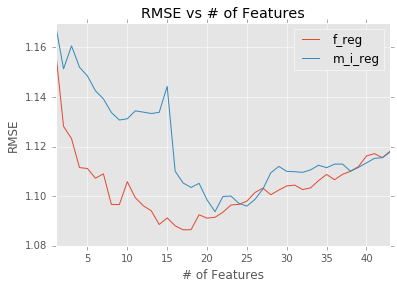

In [68]:
predictions = subset(KNR(n_neighbors=26,weights='uniform'),train,target)

predictions.plot()
plt.xlabel('# of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs # of Features')
plt.show()

In [70]:
print predictions.sort_values(by='f_reg').head(1)
print predictions.sort_values(by='m_i_reg').head(1)

       f_reg   m_i_reg
17  1.086448  1.105315
       f_reg   m_i_reg
21  1.091503  1.093763


In [73]:
clf = SelectKBest(f_regression,k=17)
clf.fit(train,target)
knr_cols = train.columns[clf.get_support(True)]
knr_cols

Index([u'Self-consciousness', u'Self-discipline', u'Sympathy', u'Modesty',
       u'Adventurousness', u'Gregariousness', u'Intellect', u'Imagination',
       u'Cheerfulness', u'Liberalism', u'WORDS', u'LENGTH', u'ADP', u'.',
       u'CONJ', u'NUM', u'X'],
      dtype='object')

In [75]:
predictions = subset(SVR(C=2,gamma=0.005,kernel='rbf'),train,target)

       f_reg   m_i_reg
33  1.066941  1.067667
       f_reg   m_i_reg
28  1.069089  1.064078


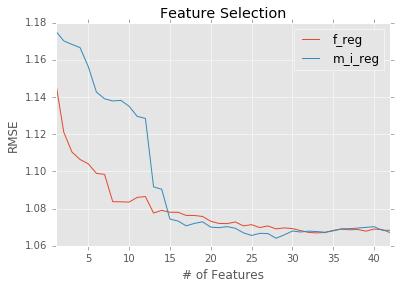

In [78]:
print predictions.sort_values(by='f_reg').head(1)
print predictions.sort_values(by='m_i_reg').head(1)

predictions.iloc[:-1].plot()
plt.title('Feature Selection')
plt.xlabel('# of Features')
plt.ylabel('RMSE')
plt.show()

In [79]:
clf = SelectKBest(mutual_info_regression,k=28)
clf.fit(train,target)
svr_cols = train.columns[clf.get_support(True)]
svr_cols

Index([u'Dutifulness', u'Self-consciousness', u'Orderliness',
       u'Self-discipline', u'Excitement-seeking', u'Cautiousness',
       u'Emotionality', u'Vulnerability', u'Immoderation', u'Sympathy',
       u'Friendliness', u'Altruism', u'Adventurousness', u'Gregariousness',
       u'Intellect', u'Artistic interests', u'Depression', u'Trust',
       u'Cheerfulness', u'Liberalism', u'WORDS', u'LENGTH', u'NOUN', u'ADP',
       u'ADJ', u'ADV', u'CONJ', u'NUM'],
      dtype='object')

## Neural Networks (Work in progress)

Neural Networks play a very important role in today's machine learning, see how they behave with the tasks at hand.

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD, Adamax
from keras.layers import Dropout

Using Theano backend.


### Regression

Prepare the dataset and target.

In [ ]:
index  = ~dfpp['imdbRating'].isnull()
Y      = dfpp['imdbRating'].ix[index].values
X      = dfpp[dfpp.columns[:44]].ix[index].values

Define a NN regression model:

- input_dim     = 44 features
- hidden layers = 1 with 19 nodes
- output layer  = 1 node

Parameters:
- init       = normal
- activation = softplus
- optimizer  = Adamax
- loss       = mse or mae

In [ ]:
def reg_model(input_dim=44):
    model = Sequential()
    model.add(Dense(19,input_dim=input_dim,init='normal',activation='softplus'))
    model.add(Dense(1,init='normal'))
    model.compile(loss='mse',optimizer='Adamax')
    return model

Prepare data and perform 5 fold cross validation. The number of epochs and batch size were also adjusted for the lowest RMSE.

In [167]:
seed = 7
np.random.seed(seed)

estimator = KerasRegressor(build_fn=reg_model,nb_epoch=100,batch_size=30,verbose=0)

kfold   = KFold(n_splits=5,random_state=seed)
results = cross_val_score(estimator,X,Y,cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 1.16 (0.15) MSE


### Classification

As before, define a NN that will tackle the classification task. The main differences are:

- Output layer =  1 node per output, 18 total.
- loss function = categorical_crossentropy.
- metrics = accuracy.

In [229]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.constraints import maxnorm

Extract just values from the previously created dataset and target.

In [212]:
XC  = train.values     
YC  = target1.values

Check # of categories.

In [213]:
len(np.unique(YC))

18

Encode the target values to be used with the NN, then run the training.

In [238]:
encoder   = LabelEncoder()
encoder.fit(YC)

encoded_Y = encoder.transform(YC)
dummy_y   = np_utils.to_categorical(encoded_Y)

Define classification model.

In [249]:
def cla_model(input_dim=44):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(input_dim,)))
    model.add(Dense(100,init='normal',activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(100,init='normal',activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(18,init='normal'))
    model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])
    return model

Train the NN.

In [250]:
seed = 7
np.random.seed(seed)

estimator = KerasClassifier(build_fn=cla_model,nb_epoch=500, batch_size=40, verbose=0)

kfold     = KFold(n_splits=5, shuffle=True, random_state=seed)
results   = cross_val_score(estimator, XC, dummy_y, cv=kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 17.96% (6.10%)
